In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# 加载训练数据
#数据预处理
order_train = pd.read_csv('data/order_train2.csv')
# 将订单数据中的日期从字符串类型转换为日期类型
order_train['order_date'] = pd.to_datetime(order_train['order_date'])
# order_train = order_train[(order_train['order_date'].dt.year == 2018) & (order_train['order_date'].dt.month >=7)]
order_train['year'] = order_train['order_date'].dt.year
order_train['month'] = order_train['order_date'].dt.month
order_train['day'] = order_train['order_date'].dt.day
order_train['weekday'] = order_train['order_date'].dt.weekday
order_train['week'] = order_train['order_date'].dt.isocalendar().week.astype('int64')
order_train["season"] = ((order_train["order_date"].dt.month-1)//3+1)

order_train = order_train[order_train['ord_qty'] < order_train['ord_qty'].quantile(0.99)]  # 清除需求量极大异常值
# order_train['sales_chan_name'] = order_train['sales_chan_name'].replace({'online': 0, 'offline': 1})
print(order_train.info())
predict_df = pd.read_csv('data/predict_sku1.csv')
print('查看是否有重复值')
print(predict_df.duplicated().sum()) #发现没有重复值
print(predict_df.describe())
print(predict_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591398 entries, 0 to 597381
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         591398 non-null  datetime64[ns]
 1   sales_region_code  591398 non-null  int64         
 2   item_code          591398 non-null  int64         
 3   first_cate_code    591398 non-null  int64         
 4   second_cate_code   591398 non-null  int64         
 5   sales_chan_name    591398 non-null  object        
 6   item_price         591398 non-null  float64       
 7   ord_qty            591398 non-null  int64         
 8   year               591398 non-null  int64         
 9   month              591398 non-null  int64         
 10  day                591398 non-null  int64         
 11  weekday            591398 non-null  int64         
 12  week               591398 non-null  int64         
 13  season             591398 non-null  int64   

In [16]:
code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
for cc in code_columns:
    order_train[cc] = order_train[cc].astype('category')
order_train = pd.get_dummies(order_train, columns=code_columns, drop_first=True)

order_train['month_sin'] = np.sin((order_train['month'] - 1) * (2.0 * np.pi / 12))
order_train['month_cos'] = np.cos((order_train['month'] - 1) * (2.0 * np.pi / 12))
order_train['season_sin'] = np.sin((order_train['season'] - 1) * (2.0 * np.pi / 4))
order_train['season_cos'] = np.cos((order_train['season'] - 1) * (2.0 * np.pi / 4))
selected_features = order_train.columns.drop(['order_date', 'ord_qty','item_price','sales_chan_name','sales_region_code_104'])
print(selected_features)

Index(['item_code', 'year', 'month', 'day', 'weekday', 'week', 'season',
       'sales_region_code_102', 'sales_region_code_103',
       'sales_region_code_105', 'first_cate_code_302', 'first_cate_code_303',
       'first_cate_code_304', 'first_cate_code_305', 'first_cate_code_306',
       'first_cate_code_307', 'first_cate_code_308', 'second_cate_code_402',
       'second_cate_code_403', 'second_cate_code_404', 'second_cate_code_405',
       'second_cate_code_406', 'second_cate_code_407', 'second_cate_code_408',
       'second_cate_code_409', 'second_cate_code_410', 'second_cate_code_411',
       'second_cate_code_412', 'month_sin', 'month_cos', 'season_sin',
       'season_cos'],
      dtype='object')


In [174]:
# 计算每个特征与输出变量之间的相关系数，并将它们按相关系数从高到低排列
# corr = order_train.corrwith(order_train['ord_qty']).sort_values(ascending=False)
# print(corr)
# c = list(corr.index)
# selected_features = c[1:16]
# print(selected_features)

ord_qty                  1.000000
first_cate_code_306      0.088874
second_cate_code_407     0.072486
second_cate_code_402     0.059920
first_cate_code_308      0.049780
second_cate_code_404     0.049780
season_cos               0.040016
first_cate_code_307      0.039176
second_cate_code_403     0.039176
month_cos                0.035878
weekday                  0.030556
sales_region_code_103    0.018876
sales_region_code_104    0.010652
month_sin                0.007520
item_code                0.004315
sales_region_code_102    0.000268
season_sin              -0.004599
day                     -0.012220
second_cate_code_405    -0.016227
first_cate_code_305     -0.021980
second_cate_code_412    -0.021980
season                  -0.022672
month                   -0.024993
first_cate_code_304     -0.025365
second_cate_code_409    -0.025365
week                    -0.025845
second_cate_code_411    -0.027200
sales_region_code_105   -0.033949
second_cate_code_410    -0.046865
second_cate_co

In [17]:
from sklearn.model_selection import train_test_split

# 划分数据集为训练集和测试集，其中训练集占比为 0.8
X_train, X_test, y_train, y_test = train_test_split(order_train[selected_features], order_train['ord_qty'], test_size=0.2, random_state=42)


In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}
model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params) #最优参数{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 200}

D:\program file\py3\py3.88\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 200}


In [6]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

best_params = {'max_depth': 15,  'min_samples_leaf': 5, 'n_estimators': 200}

model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, n_estimators=200,
                      random_state=42)

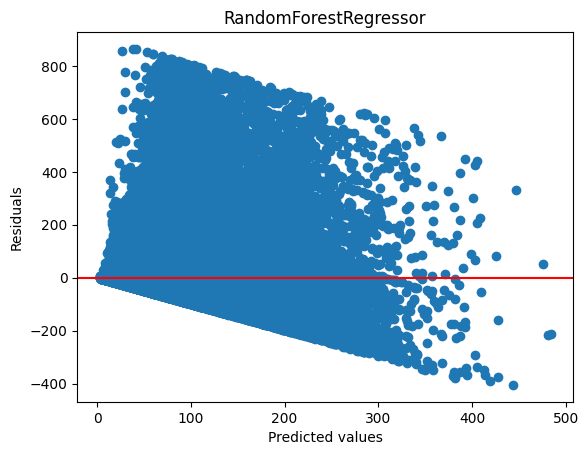

In [19]:
y_pred = model.predict(X_test)

# 计算残差
residuals = y_test - y_pred

# 绘制残差图
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('RandomForestRegressor')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

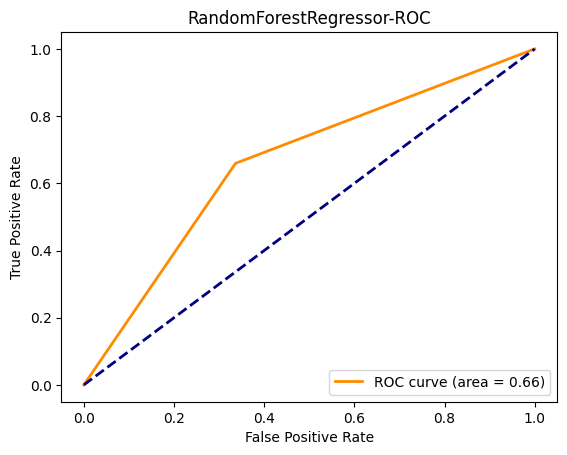

In [25]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = model.predict(X_test)

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(np.where(y_test >= np.median(y_test), 1, 0), np.where(y_pred >= np.median(y_pred), 1, 0))
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestRegressor-ROC')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score
# 对模型进行预测
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 计算均方误差（MSE）、均方根误差（RMSE）、平均绝对误差（MAE）
print('MSE:', mse)
print('RMSE:',rmse )
print('MAE:', mae)
print('R2:',r2 )
# MSE: 6720.620717909003
# RMSE: 81.97939203183324
# MAE: 46.137341659570964
# R2: 0.2683982244038451

MSE: 12638.262244121534
RMSE: 112.42002599235393
MAE: 68.12664513094613
R2: 0.17431100715628467


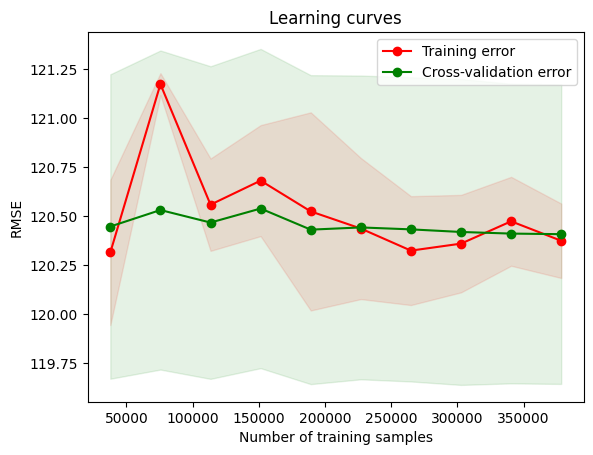

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 创建一个简单的线性回归模型
model = LinearRegression()

# 计算不同观测点下的训练集和验证集误差
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_root_mean_squared_error'
)

# 计算训练集和验证集的平均误差，以及标准差
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 绘制学习曲线
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.title('Learning curves')
plt.legend(loc='best')
plt.show()

In [7]:
predict_df = pd.read_csv('data/predict_sku1.csv')
date_range = pd.date_range(start='2019-01-01', end='2019-03-31', freq='D')
cols = ['sales_region_code', 'item_code', '2019年1月预测需求量', '2019年2月预测需求量', '2019年3月预测需求量']
predicted_demand_df = pd.DataFrame(columns=cols)
sales_region_code =     predict_df['sales_region_code']
item_code = predict_df['item_code']
    
for cc in code_columns:
    predict_df[cc] = predict_df[cc].astype('category')

predict_df = pd.get_dummies(predict_df, columns=code_columns,drop_first=True)


for _, row in predict_df.iterrows():
    predict_data = row.to_frame().transpose()

#     region = int(predict_data['sales_region_code'])
    code = int(predict_data['item_code'])
    
    # 扩展日期列
    predict_data = pd.concat([predict_data]*len(date_range), ignore_index=True)
    predict_data['date'] = date_range
   
    # 提取特征
#     predict_data['is_holiday'] = predict_data['date'].isin(holidays.China(years=2019))
    predict_data['year'] = predict_data['date'].dt.year
    predict_data['month'] = predict_data['date'].dt.month
    predict_data['weekday'] = predict_data['date'].dt.weekday
    predict_data['day'] = predict_data['date'].dt.day
    predict_data['week'] = predict_data['date'].dt.isocalendar().week.astype(int)
    predict_data["season"] = ((predict_data["date"].dt.month-1)//3+1)
    code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
    predict_data.columns.drop('date')
    predict_data['month_sin'] = np.sin((predict_data['month'] - 1) * (2.0 * np.pi / 12))
    predict_data['month_cos'] = np.cos((predict_data['month'] - 1) * (2.0 * np.pi / 12))
    predict_data['season_sin'] = np.sin((predict_data['season'] - 1) * (2.0 * np.pi / 4))
    predict_data['season_cos'] = np.cos((predict_data['season'] - 1) * (2.0 * np.pi / 4))
#     print(predict_data.columns)
    # 进行预测
    X_predict = predict_data[selected_features]
    y_predict = model.predict(X_predict)

    # 计算月总需求量
    predict_data['demand'] = y_predict
    monthly_demand = predict_data.groupby(['year', 'month'], as_index=False)['demand'].sum().astype(int)
    
    row = [1,code, 0, 0, 0]
    for _, row_month in monthly_demand.iterrows():
        month_col = '2019年{}月预测需求量'.format(int(row_month['month']))
        row[cols.index(month_col)] = row_month['demand']     
    predicted_demand_df.loc[len(predicted_demand_df)] = row
    print(predicted_demand_df)
    



   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           287           262           296
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           287           262           296
1                  1      20003          3404          2886          3485
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           287           262           296
1                  1      20003          3404          2886          3485
2                  1      20006          2490          2531          2922
   sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                  1      20002           287           262           296
1                  1      20003          3404          2886          3485
2                  1      20006          2490          2531          2922
3                  1      20011       

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
5                   1      20016          1814          1610          1915
6                   1      20018          5032          4264          5033
7                   1      20020           525           302           291
8                   1      20021           546           321           311
9                   1      20024          1879          1290          1423
10                  1      20039           546           321           311
11                  1      20041          5065          5098          6196
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
5                   1      20016          1814          1610          1915
6                   1      20018          5032          4264          5033
7                   1      20020           525           302           291
8                   1      20021           546           321           311
9                   1      20024          1879          1290          1423
10                  1      20039           546           321           311
11                  1      20041          5065          5098          6196
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
5                   1      20016          1814          1610          1915
6                   1      20018          5032          4264          5033
7                   1      20020           525           302           291
8                   1      20021           546           321           311
9                   1      20024          1879          1290          1423
10                  1      20039           546           321           311
11                  1      20041          5065          5098          6196
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
5                   1      20016          1814          1610          1915
6                   1      20018          5032          4264          5033
7                   1      20020           525           302           291
8                   1      20021           546           321           311
9                   1      20024          1879          1290          1423
10                  1      20039           546           321           311
11                  1      20041          5065          5098          6196
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
5                   1      20016          1814          1610          1915
6                   1      20018          5032          4264          5033
7                   1      20020           525           302           291
8                   1      20021           546           321           311
9                   1      20024          1879          1290          1423
10                  1      20039           546           321           311
11                  1      20041          5065          5098          6196
12                  1    

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
..                ...        ...           ...           ...           ...
57                  1      20192          5036          4571          4933
58                  1      20193          1086           915           964
59                  1      20195          1086           916           964
60                  1      20198          1077           933          1012
61                  1      20206          2584          2360          2612

[62 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
..                ...        ...           ...           ...           ...
66                  1      20226          1526          1332          1479
67                  1      20227          3255          2937          3077
68                  1      20230          1979          1798          2042
69                  1      20231          2577          2348          2557
70                  1      20235           323           295           357

[71 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
..                ...        ...           ...           ...           ...
75                  1      20251           188           167           162
76                  1      20252          2954          2590          2941
77                  1      20253          6312          5682          6321
78                  1      20254          1482          1287          1442
79                  1      20256          3543          3056          3379

[80 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
..                ...        ...           ...           ...           ...
84                  1      20278          2842          2614          2808
85                  1      20282          2849          2619          2814
86                  1      20283          4152          3696          4111
87                  1      20284          4080          3604          3986
88                  1      20285          2849          2619          2814

[89 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                   1      20002           287           262           296
1                   1      20003          3404          2886          3485
2                   1      20006          2490          2531          2922
3                   1      20011           892           769           829
4                   1      20014          6933          8004          7110
..                ...        ...           ...           ...           ...
93                  1      20305          1846          1627          1852
94                  1      20311          3117          2717          3035
95                  1      20313          2266          1981          2297
96                  1      20316          2705          2311          2646
97                  1      20320          2758          2503          2851

[98 rows x 5 columns]
    sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0 

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
102                  1      20327          1476          1263          1358
103                  1      20328          2742          2496          2846
104                  1      20329          4763          4403          4634
105                  1      20336          1475          1286          1437
106                  1      20337          1527          1308          1456

[107 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
111                  1      20346          2762          2516          2871
112                  1      20347          4878          4505          4751
113                  1      20350          4461          3221          3643
114                  1      20356          4876          4503          4744
115                  1      20357          2549          2190          2558

[116 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
120                  1      20370          4295          3064          3466
121                  1      20384          3020          2642          2927
122                  1      20387          3985          2990          3349
123                  1      20388          3879          2988          3347
124                  1      20389          1669          1286          1372

[125 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
129                  1      20399          1744          1304          1434
130                  1      20404          1464          1289          1443
131                  1      20405          1806          1428          1579
132                  1      20407          3236          2465          2719
133                  1      20413          2650          2409          2715

[134 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
138                  1      20422          1271           937          1038
139                  1      20427          1734          1279          1431
140                  1      20428          7310          6771          7566
141                  1      20429          2309          1850          2000
142                  1      20433          1877          1491          1559

[143 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
147                  1      20447          2691          2421          2715
148                  1      20449          2433          2228          2542
149                  1      20452          2198          1901          2227
150                  1      20457          4218          2634          2906
151                  1      20459          2742          2055          2165

[152 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
156                  1      20480          2781          2471          2755
157                  1      20483          2733          2120          2154
158                  1      20492          3167          2778          3075
159                  1      20494          3148          2775          3085
160                  1      20498          2979          2634          2963

[161 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
165                  1      20506          1105           945           994
166                  1      20511          4173          3733          4157
167                  1      20512          4173          3733          4157
168                  1      20515          2650          2029          2026
169                  1      20522          2641          2022          2018

[170 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
174                  1      20531          2902          2546          2808
175                  1      20538          2663          2356          2652
176                  1      20540          1063           906           952
177                  1      20545          3599          2803          3009
178                  1      20549          2838          2487          2742

[179 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
183                  1      20563          1054           992           969
184                  1      20567           394           328           258
185                  1      20569          1054           992           968
186                  1      20575          6101          5239          6044
187                  1      20580          2312          1137          1249

[188 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
193                  1      20597          1248           968          1316
194                  1      20600          3751          2878          3180
195                  1      20604          3788          2884          3180
196                  1      20614          2686          2276          2488
197                  1      20616          2150          1877          2079

[198 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
202                  1      20628          1524          1397          1589
203                  1      20631          4019          3117          3456
204                  1      20635          1316           960          1207
205                  1      20636          2140          1922          2138
206                  1      20648          4995          3925          3945

[207 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
211                  1      20656          2875          2376          2625
212                  1      20657           347           318           329
213                  1      20658          2875          2376          2625
214                  1      20661          3680          2904          3646
215                  1      20662          3008          2600          2817

[216 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
220                  1      20674          4700          4142          4947
221                  1      20675          3658          2878          3219
222                  1      20678          2957          2309          2758
223                  1      20682          2218          1940          2154
224                  1      20683          4472          2220          2756

[225 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
230                  1      20696          1367          1095           960
231                  1      20697          2805          2439          2688
232                  1      20699          2147          1903          2112
233                  1      20700          2147          1903          2112
234                  1      20701          4453          2169          2685

[235 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
239                  1      20716          1513          1306          1453
240                  1      20717          1513          1306          1453
241                  1      20720          1866          1575          1687
242                  1      20722          2397          2088          2321
243                  1      20727          3224          2155          2620

[244 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
248                  1      20738          1286          1046           902
249                  1      20739          1541          1250          1118
250                  1      20740          2716          2354          2606
251                  1      20742          3082          2628          3013
252                  1      20743          1594          1306          1243

[253 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
257                  1      20763          3305          2863          3340
258                  1      20764          1587          1301          1233
259                  1      20766          2421          2131          2371
260                  1      20768          2662          2202          2482
261                  1      20775          2410          2107          2345

[262 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
266                  1      20795          3913          2979          3326
267                  1      20797          1292          1064          1388
268                  1      20803          2738          2359          2610
269                  1      20804          1952          1450          1696
270                  1      20805          2497          2211          2452

[271 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
276                  1      20827          2025          1697          1653
277                  1      20828          2617          2331          3446
278                  1      20830          3575          2854          3189
279                  1      20831          2916          2521          2734
280                  1      20840          1165          1011          1145

[281 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
285                  1      20854          2012          1476          1697
286                  1      20855          2666          2291          2482
287                  1      20858          5099          4643          5269
288                  1      20859          2663          2289          2479
289                  1      20862          3566          2853          3194

[290 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
294                  1      20880          1404          1208          2080
295                  1      20882          2679          2301          2484
296                  1      20886           346           313           330
297                  1      20892          1696          1528          1675
298                  1      20896          3666          2978          3353

[299 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
303                  1      20913          2883          2653          2997
304                  1      20915          3096          2770          3133
305                  1      20916          4151          3812          4339
306                  1      20920          6068          5505          6112
307                  1      20922           988           834          1342

[308 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
312                  1      20942          7380          6138          5513
313                  1      20944          2035          1750          2003
314                  1      20947          2776          2563          2847
315                  1      20953          2087          1558          1839
316                  1      20956          1832          1670          1852

[317 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
321                  1      20978          2121          1447          1513
322                  1      20980          1742          1577          1799
323                  1      20981          2072          1889          2107
324                  1      20984          2358          2200          2456
325                  1      20985          1695          1527          1743

[326 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
330                  1      20999          2127          1449          1517
331                  1      21000          1762          1590          2024
332                  1      21005          3226          2840          3358
333                  1      21016          3102          2647          3113
334                  1      21023          2660          2285          2531

[335 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
339                  1      21036           239           191           173
340                  1      21038          3072          2544          2906
341                  1      21039          2700          2319          2571
342                  1      21043          2700          2319          2571
343                  1      21044          1203          1299          1646

[344 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
348                  1      21057          1770          1575          1747
349                  1      21059          1392          1227          1543
350                  1      21061          4271          3574          4013
351                  1      21062          1391          1218          1527
352                  1      21064          3230          2669          2988

[353 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
357                  1      21081          3196          2755          3039
358                  1      21082          2846          2460          2695
359                  1      21084          2242          1921          2117
360                  1      21088          1730          1551          1857
361                  1      21090          1381          1202          1536

[362 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
366                  1      21103          2228          1939          2187
367                  1      21106          2228          1939          2187
368                  1      21109          1425          1213          1597
369                  1      21110          2556          2224          2505
370                  1      21111           415           305           313

[371 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
376                  1      21125          2295          2017          2303
377                  1      21127          1374          1149          1488
378                  1      21129          1610          1163          1495
379                  1      21147          2160          1910          2220
380                  1      21149          2358          2067          2377

[381 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
386                  1      21168          2447          2088          2395
387                  1      21174           910           733           735
388                  1      21182          1003           908          1037
389                  1      21183          2346          2064          2370
390                  1      21184          1003           908          1037

[391 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
395                  1      21198          1924          1701          2028
396                  1      21201          1895          1678          2001
397                  1      21212          1907          1688          2015
398                  1      21215           839           762           865
399                  1      21220          2598          2043          2197

[400 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
404                  1      21237          5996          5275          5494
405                  1      21238          4561          3877          4165
406                  1      21239          5910          5203          5412
407                  1      21240          1331          1129          1453
408                  1      21245          1331          1129          1456

[409 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
414                  1      21271          7616          6262          6415
415                  1      21274          4483          2270          2571
416                  1      21280          1262          1147          1356
417                  1      21284          1233          1120          1320
418                  1      21285          1234          1120          1325

[419 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
423                  1      21297          1223          1111          1327
424                  1      21298          1238          1124          1346
425                  1      21304          1959          1528          2113
426                  1      21306          1236          1124          1350
427                  1      21312          1817          1325          1759

[428 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
433                  1      21330          1170          1051          1170
434                  1      21340          1711          1492          1737
435                  1      21346          1163          1100          1344
436                  1      21354          4560          3419          3724
437                  1      21357           241           194           176

[438 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
443                  1      21373          1544          1327          1465
444                  1      21376          4612          3438          3751
445                  1      21379          1393          1266          1266
446                  1      21381          1137           952          1102
447                  1      21386          1113           929          1082

[448 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
452                  1      21409           403           338           419
453                  1      21410          5984          4558          5353
454                  1      21415          1820          1695          1627
455                  1      21416          5367          4191          4765
456                  1      21418           399           333           405

[457 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
461                  1      21431          1373          1189          1581
462                  1      21432          6142          5354          5995
463                  1      21433          2286          1914          2163
464                  1      21435          6275          5476          6127
465                  1      21437          1357          1137          1492

[466 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
470                  1      21454          2223          1826          2109
471                  1      21456          1896          1520          1817
472                  1      21460           344           295           277
473                  1      21462          2269          1879          2115
474                  1      21465          1407          1202          1555

[475 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
479                  1      21488          2173          1681          1888
480                  1      21490          1645          1205          1429
481                  1      21492          1645          1205          1429
482                  1      21496          2174          1681          1888
483                  1      21497          1631          1205          1429

[484 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
488                  1      21521          1920          1403          1572
489                  1      21523          2609          2074          2312
490                  1      21524          3061          2495          2738
491                  1      21527          3607          2961          3340
492                  1      21529          3605          2975          3335

[493 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
498                  1      21550          2750          2167          2571
499                  1      21555           391           327           374
500                  1      21557          4282          3442          3852
501                  1      21558          1222          1044          1352
502                  1      21561          4292          3322          3746

[503 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
507                  1      21589          5178          4352          4921
508                  1      21596          1223          1058          1366
509                  1      21597          1223          1058          1366
510                  1      21601          5239          4385          4957
511                  1      21602          3690          2968          3355

[512 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
516                  1      21614          3708          2968          3355
517                  1      21617           940           851           942
518                  1      21619          4374          3487          3895
519                  1      21626          2186          1900          2102
520                  1      21630          2186          1900          2102

[521 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
525                  1      21642          1036           932          1028
526                  1      21644          2107          1873          2057
527                  1      21648          2468          2128          2332
528                  1      21650          2211          1982          2200
529                  1      21651          2270          1943          2153

[530 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
534                  1      21669          1993          1901          1844
535                  1      21681          1798           949          1260
536                  1      21683          1798           950          1283
537                  1      21684          2735          2379          2612
538                  1      21687          2367          2060          2277

[539 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
543                  1      21709          4134          2315          2739
544                  1      21714          4260          2419          2849
545                  1      21715          4898          3139          3555
546                  1      21719          2364          2065          2284
547                  1      21730          3376          2050          2152

[548 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
552                  1      21743          2865          2444          2655
553                  1      21745          1162          1012          1105
554                  1      21749          1184          1031          1127
555                  1      21751          2748          2358          2593
556                  1      21754          1885          1806          1819

[557 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
561                  1      21772          2866          2441          2644
562                  1      21775          2078          2030          2130
563                  1      21777          2076          2020          2121
564                  1      21779          3784          3200          3551
565                  1      21780          2398          2110          2352

[566 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
570                  1      21793           346           320           390
571                  1      21794          2452          2158          2406
572                  1      21795          2461          2159          2406
573                  1      21807           359           302           336
574                  1      21808           356           300           329

[575 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
579                  1      21822          3955          3408          3782
580                  1      21823          2048          2101          2176
581                  1      21835          2580          2178          2458
582                  1      21839          3952          3408          3779
583                  1      21845          2100          2213          2237

[584 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
589                  1      21864          1745          1685          1797
590                  1      21865          2813          2438          2744
591                  1      21867          2455          2157          2558
592                  1      21871          2822          2439          2744
593                  1      21878          1731          1641          1653

[594 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
598                  1      21895          4386          3850          4415
599                  1      21900          4035          3512          3890
600                  1      21903          1699          1608          1643
601                  1      21909           736           604           621
602                  1      21911          3273          2852          3193

[603 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
607                  1      21917          1696          1605          1640
608                  1      21922          3273          2852          3193
609                  1      21923          4020          3470          3839
610                  1      21928          3324          2919          3240
611                  1      21940           693           562           565

[612 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
616                  1      21962          3540          2206          2005
617                  1      21964           514           452           518
618                  1      21966          3974          3433          3794
619                  1      21967          1717          1621          1734
620                  1      21969          3816          3706          4350

[621 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
626                  1      21986          2484          2195          2630
627                  1      21995          3045          2641          2957
628                  1      22007          1699          1577          1750
629                  1      22008          2314          2063          2346
630                  1      22013          3906          3006          3016

[631 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
635                  1      22027          3168          2745          3092
636                  1      22028          1949          1779          1766
637                  1      22030          3903          3469          3889
638                  1      22035          1347          1283          1248
639                  1      22038          3040          2643          2957

[640 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
644                  1      22048          3076          2680          2997
645                  1      22053          3025          2623          2921
646                  1      22056          3995          4283          5181
647                  1      22058          2815          2913          3144
648                  1      22059          1839          1754          1988

[649 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
653                  1      22084          2627          2697          2887
654                  1      20002           498           444           498
655                  1      20003          3262          2605          3242
656                  1      20006          2508          2518          2968
657                  1      20008           859           763           807

[658 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
663                  1      20024          1887          1309          1442
664                  1      20025          4917          4822          5671
665                  1      20033          1589          1144          1252
666                  1      20038          1590          1145          1253
667                  1      20041          4917          4822          5671

[668 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
672                  1      20055          1741          1243          1364
673                  1      20056           794           551           740
674                  1      20074          2517          2177          2361
675                  1      20075          2517          2177          2361
676                  1      20076          1602          1215          1056

[677 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
681                  1      20091          2556          2161          2348
682                  1      20092          2043          1116          1253
683                  1      20093          2113          1178          1327
684                  1      20107          2244          1296          1426
685                  1      20111          2253          1296          1426

[686 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
690                  1      20131          5878          4701          4795
691                  1      20134          1091           684           801
692                  1      20135          1722          1325          1076
693                  1      20139          7134          5704          5439
694                  1      20145          1206           862           934

[695 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
700                  1      20156          2876          2155          2475
701                  1      20160          1776          1612          1776
702                  1      20162          1267           933          1155
703                  1      20164           931           844           930
704                  1      20165          2876          2155          2475

[705 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
710                  1      20176          1308          1024          1087
711                  1      20182          1193           912           724
712                  1      20187           987           863           924
713                  1      20189          2282          1992          2247
714                  1      20191          2282          1992          2247

[715 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
719                  1      20215           916           776           826
720                  1      20221           806           756           798
721                  1      20222           922           801           884
722                  1      20224          4430          3727          4075
723                  1      20226          1975          2086          4031

[724 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
728                  1      20240          1931          1656          1859
729                  1      20251           184           163           157
730                  1      20252          2145          1732          1944
731                  1      20253          6275          5634          6269
732                  1      20254          1014           891           774

[733 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
737                  1      20271          3498          3052          3408
738                  1      20272          4442          4047          4278
739                  1      20276          3495          3049          3405
740                  1      20278          2550          2343          2529
741                  1      20283          4285          3746          4179

[742 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
746                  1      20300          2767          2702          2896
747                  1      20304          1412          1315          1469
748                  1      20311          3082          2698          3031
749                  1      20312          2784          2519          2863
750                  1      20313          1941          1717          1982

[751 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
756                  1      20325          4578          4225          4471
757                  1      20328          2747          2496          2842
758                  1      20329          4592          4238          4484
759                  1      20336          1306          1185          1207
760                  1      20337          1371          1232          1565

[761 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
765                  1      20347          4692          4332          4593
766                  1      20356          4690          4329          4586
767                  1      20357          2619          2235          2620
768                  1      20366          1377          1098          1144
769                  1      20368          2862          2599          2959

[770 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
774                  1      20391          2834          2566          2895
775                  1      20392          2984          2704          3043
776                  1      20394           181           161           151
777                  1      20397          3099          2730          3038
778                  1      20398          1111           994          1034

[779 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
783                  1      20408          1903          2175          2550
784                  1      20412          2585          2359          2657
785                  1      20413          2648          2406          2708
786                  1      20414          3818          3432          3820
787                  1      20416          2417          2065          2407

[788 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
792                  1      20427          1738          1070          1131
793                  1      20433          1442          1141          1249
794                  1      20434          2425          2221          2523
795                  1      20438          2638          2375          2668
796                  1      20443           612           549           577

[797 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
802                  1      20459          2610          1901          2024
803                  1      20461           382           328           266
804                  1      20462          1374           994          1060
805                  1      20463          2684          2417          2714
806                  1      20472          3803          3411          3823

[807 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
811                  1      20483          2691          2025          2094
812                  1      20490          2729          2418          2712
813                  1      20492          3148          2773          3077
814                  1      20494          3097          2729          3038
815                  1      20501          3195          2831          3182

[816 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
820                  1      20512          3947          3478          3924
821                  1      20515          2578          1922          1938
822                  1      20522          2568          1914          1929
823                  1      20523          4231          3716          4196
824                  1      20525          2397          2045          2373

[825 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
829                  1      20546          1523          1047          1101
830                  1      20549          2823          2483          2752
831                  1      20552          4077          3572          4028
832                  1      20554          3375          2601          2724
833                  1      20555          4077          3572          4028

[834 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
838                  1      20576          1731          1043          1099
839                  1      20580          1731          1043          1099
840                  1      20583          7537          6127          7431
841                  1      20584          2064          1841          2128
842                  1      20587          1998          1797          2020

[843 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
847                  1      20604          3821          2919          3228
848                  1      20610           501           455           497
849                  1      20614          2665          2243          2461
850                  1      20618          4273          3196          3560
851                  1      20620           941           759           871

[852 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
856                  1      20637          2134          1915          2136
857                  1      20648          4629          3685          3649
858                  1      20649          4478          3799          4672
859                  1      20654          3554          2795          3121
860                  1      20655          2140          1916          2134

[861 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
865                  1      20661          2867          1927          1572
866                  1      20664          3644          2882          3233
867                  1      20666          3668          2891          3243
868                  1      20668          2659          2347          2606
869                  1      20674          5214          4480          5446

[870 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
874                  1      20693          7913          6907          7387
875                  1      20696          1344          1084          1000
876                  1      20697          2803          2430          2682
877                  1      20699          2152          1907          2123
878                  1      20700          2152          1907          2123

[879 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
883                  1      20709          3918          1760          1690
884                  1      20711          2750          2370          2620
885                  1      20712          2394          2087          2325
886                  1      20717          1390          1046          1095
887                  1      20720          1552          1151          1205

[888 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
892                  1      20734          2495          2208          2451
893                  1      20736          3127          2643          3034
894                  1      20737          3127          2643          3034
895                  1      20738          1273          1008           930
896                  1      20739          1535          1210          1232

[897 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
901                  1      20753          3127          2648          3039
902                  1      20759          1548          1268          1458
903                  1      20761          1543          1252          1400
904                  1      20763          3354          2879          3361
905                  1      20764          1526          1203          1295

[906 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
910                  1      20782           234           189           172
911                  1      20786          1204          1000          1033
912                  1      20795          3946          3005          3363
913                  1      20797          1221           973          1428
914                  1      20803          2750          2358          2609

[915 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
919                  1      20816          3173          2705          2945
920                  1      20820          3241          2768          2994
921                  1      20822          3241          2768          2994
922                  1      20824          3131          2674          2942
923                  1      20827          1205          1049          1165

[924 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
928                  1      20841          3571          2857          3198
929                  1      20842          2341          2009          2268
930                  1      20849          2505          2215          3343
931                  1      20854          1965          1457          1687
932                  1      20859          2603          2257          2435

[933 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
938                  1      20879          1422          1215          2105
939                  1      20880          1422          1215          2105
940                  1      20882          2614          2265          2437
941                  1      20886           360           323           362
942                  1      20892          1606          1445          1577

[943 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
947                  1      20911          2023          1745          2040
948                  1      20912           990           842          1403
949                  1      20913          2936          2704          3049
950                  1      20914          1977          1448          1679
951                  1      20916          4077          3748          4264

[952 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
956                  1      20934          7322          6066          5445
957                  1      20937          2284          1941          2214
958                  1      20939          2287          1957          2223
959                  1      20940           386           339           364
960                  1      20944          2118          1823          2106

[961 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
965                  1      20960          2583          2386          2667
966                  1      20969          2540          2320          2606
967                  1      20973          6155          5296          5983
968                  1      20976          2794          2690          2996
969                  1      20980          1234          1037          1219

[970 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
974                  1      20996          5193          4521          5376
975                  1      20997          2194          1485          1573
976                  1      20998          2608          1523          1678
977                  1      21000          1806          1614          2074
978                  1      21003          3923          3470          4236

[979 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
984                  1      21028          2710          2331          2594
985                  1      21034          2710          2331          2594
986                  1      21036           234           189           172
987                  1      21037          2940          2461          2797
988                  1      21038          2940          2461          2797

[989 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                    1      20002           287           262           296
1                    1      20003          3404          2886          3485
2                    1      20006          2490          2531          2922
3                    1      20011           892           769           829
4                    1      20014          6933          8004          7110
..                 ...        ...           ...           ...           ...
994                  1      21054          3036          2564          2900
995                  1      21055           302           265           307
996                  1      21057           440           330           385
997                  1      21061          4175          3508          3950
998                  1      21064          3142          2610          2932

[999 rows x 5 columns]
     sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1003                  1      21081          3193          2758          3053
1004                  1      21082          2873          2493          2736
1005                  1      21086           647           549           591
1006                  1      21088          1806          1585          1916
1007                  1      21094          2233          1950          2172

[1008 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1013                  1      21110          2563          2237          2528
1014                  1      21111           508           360           310
1015                  1      21115          2516          2189          2491
1016                  1      21117          2233          1949          2229
1017                  1      21119          1191           954          1015

[1018 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1023                  1      21154          2101          1869          2259
1024                  1      21157          2439          2098          2408
1025                  1      21158          2021          1796          2172
1026                  1      21160          2008          1783          2159
1027                  1      21164           874           654           669

[1028 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1032                  1      21182           278           252           304
1033                  1      21183          2349          2074          2389
1034                  1      21184           278           252           304
1035                  1      21188           509           369           316
1036                  1      21192           249           227           282

[1037 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1041                  1      21206          1932          1716          2079
1042                  1      21212          1944          1726          2093
1043                  1      21215           377           337           392
1044                  1      21224          2343          2155          2562
1045                  1      21225          2343          2155          2562

[1046 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1050                  1      21245          1100           806           842
1051                  1      21249          5760          5265          5602
1052                  1      21250           430           384           433
1053                  1      21253          5055          4383          4312
1054                  1      21255          4864          4116          3982

[1055 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1059                  1      21279          1200           875           941
1060                  1      21280          1260          1139          1349
1061                  1      21282          1200           875           943
1062                  1      21284          1245          1125          1330
1063                  1      21285          1246          1125          1335

[1064 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1076                  1      21329          4452          3393          3724
1077                  1      21330           600           540           574
1078                  1      21340          1746          1518          1734
1079                  1      21342          3065          3062          3670
1080                  1      21346          1127          1052          1277

[1081 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1086                  1      21359          4048          3488          3888
1087                  1      21361          3233          2982          3836
1088                  1      21363          2036          1618          1731
1089                  1      21373          1606          1383          1530
1090                  1      21376          4470          3391          3726

[1091 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1096                  1      21398          5089          4040          4579
1097                  1      21406          1905          1766          2198
1098                  1      21407          5089          4040          4579
1099                  1      21409           275           257           243
1100                  1      21415          1816          1676          1612

[1101 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1105                  1      21431          1489          1820          2226
1106                  1      21432          6537          5766          6378
1107                  1      21433          2387          2011          2250
1108                  1      21435          6702          5919          6543
1109                  1      21437          1383          1591          1898

[1110 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1114                  1      21449          1319          1265          1568
1115                  1      21452           337           288           276
1116                  1      21454          2204          1805          2072
1117                  1      21456          1901          1519          1801
1118                  1      21460           337           288           276

[1119 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1123                  1      21480           303           273           306
1124                  1      21484          2332          2168          2212
1125                  1      21488          2204          1716          1930
1126                  1      21490          1657          1216          1426
1127                  1      21492          1657          1216          1426

[1128 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1132                  1      21511          1976          1472          1641
1133                  1      21517          1921          1405          1566
1134                  1      21518          2145          2021          1985
1135                  1      21523          2635          2080          2309
1136                  1      21524          3106          2528          2779

[1137 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1142                  1      21550          2838          2206          2644
1143                  1      21555           283           285           287
1144                  1      21557          4371          3496          3926
1145                  1      21558           652           527           545
1146                  1      21561          4353          3341          3763

[1147 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1151                  1      21585           659           563           576
1152                  1      21589          5211          4367          4933
1153                  1      21592          4252          3561          4006
1154                  1      21596           664           572           598
1155                  1      21597           663           571           585

[1156 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1161                  1      21619          4400          3515          3938
1162                  1      21625           643           542           547
1163                  1      21626          2531          2148          2363
1164                  1      21630          2531          2148          2363
1165                  1      21639          2652          2242          2494

[1166 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1170                  1      21653          2460          2133          2354
1171                  1      21657          2450          2132          2352
1172                  1      21662           689           530           517
1173                  1      21664          3000          2597          2852
1174                  1      21667          3000          2597          2852

[1175 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1180                  1      21698          2712          2284          2561
1181                  1      21703          1839          1747          1734
1182                  1      21709          3687          2284          2590
1183                  1      21712          2372          2072          2299
1184                  1      21713          1840          1748          1735

[1185 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1189                  1      21739          2369          2068          2296
1190                  1      21740          2889          2488          2722
1191                  1      21743          2891          2490          2724
1192                  1      21745           700           613           634
1193                  1      21749           706           616           642

[1194 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1198                  1      21768          2906          2500          2724
1199                  1      21772          2906          2500          2724
1200                  1      21775          1776          1566          1388
1201                  1      21777          1777          1561          1385
1202                  1      21779          3838          3321          3699

[1203 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1207                  1      21795          2483          2184          2429
1208                  1      21801          2293          1996          2372
1209                  1      21807           304           310           299
1210                  1      21809          3960          3467          3858
1211                  1      21814          2868          2489          2796

[1212 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1217                  1      21839          3955          3467          3852
1218                  1      21842          1953          1846          1838
1219                  1      21845          1819          1745          1450
1220                  1      21855          1583          1381          1289
1221                  1      21862          3198          2721          3080

[1222 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1226                  1      21881          3326          2918          3274
1227                  1      21883          3346          2936          3294
1228                  1      21884          3319          2902          3255
1229                  1      21888          3295          2880          3224
1230                  1      21892          1020           905           985

[1231 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1235                  1      21909           528           516           475
1236                  1      21911          3316          2897          3240
1237                  1      21913          3316          2897          3240
1238                  1      21914          3316          2897          3240
1239                  1      21915           935           828           900

[1240 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1245                  1      21928          4371          4006          4587
1246                  1      21940           520           506           476
1247                  1      21942          3316          2897          3240
1248                  1      21951          4023          3524          3898
1249                  1      21953          4019          3520          3893

[1250 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1254                  1      21969          2954          2519          1944
1255                  1      21974          3108          2705          3024
1256                  1      21977          4018          3524          3899
1257                  1      21978          4281          3793          4202
1258                  1      21979          3109          2705          3024

[1259 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1263                  1      21995          3109          2705          3024
1264                  1      22002          1882          1703          1786
1265                  1      22005          3478          3225          3719
1266                  1      22006          1621          1400          1548
1267                  1      22007          1554          1301          1476

[1268 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1273                  1      22030          3971          3545          3982
1274                  1      22035          1276          1227          1204
1275                  1      22038          3104          2707          3024
1276                  1      22040          3210          2868          3210
1277                  1      22045          1080           751           679

[1278 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1282                  1      22056          2486          1936          2541
1283                  1      22058          1956          1622          1904
1284                  1      22059          1836          1799          2163
1285                  1      22061          2817          2419          2691
1286                  1      22066          5908          5555          6350

[1287 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1291                  1      20003          2895          2296          2770
1292                  1      20006          2041          1805          2154
1293                  1      20011           880           771           818
1294                  1      20014          5549          5470          5687
1295                  1      20016          2078          1855          2186

[1296 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1300                  1      20038          1578          1166          1336
1301                  1      20039           585           406           403
1302                  1      20041          2304          2152          2404
1303                  1      20046          1890          1686          1901
1304                  1      20049          1886          1627          1747

[1305 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1309                  1      20086          4777          4345          4812
1310                  1      20088          3060          2466          2829
1311                  1      20089          1891          1228          1402
1312                  1      20091          3060          2466          2829
1313                  1      20093          1819          1087          1261

[1314 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1319                  1      20119          1657          1342          1514
1320                  1      20121          1807          1093          1263
1321                  1      20123          2263          1686          1881
1322                  1      20127          2069          1572          1713
1323                  1      20131          3296          2836          3369

[1324 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1328                  1      20145          1472          1268          1495
1329                  1      20146          2000          1671          1881
1330                  1      20147          1762          1417          1631
1331                  1      20150          1780          1434          1667
1332                  1      20152          2947          2572          2976

[1333 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1337                  1      20162          2030          1712          2019
1338                  1      20164          1394          1249          1479
1339                  1      20165          2933          2559          2962
1340                  1      20169          3129          2539          2921
1341                  1      20172          1397          1250          1481

[1342 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1347                  1      20187          1891          1465          1655
1348                  1      20189          2575          2502          2847
1349                  1      20191          2575          2502          2847
1350                  1      20192          5295          4464          4926
1351                  1      20193          1835          1343          1370

[1352 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1357                  1      20215          1834          1342          1367
1358                  1      20221          1172          1079          1265
1359                  1      20222          2004          1609          1806
1360                  1      20224          4996          4166          4591
1361                  1      20225           322           284           341

[1362 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1366                  1      20238          2187          1641          1817
1367                  1      20240          2426          2113          2457
1368                  1      20246          4063          3428          3857
1369                  1      20248          4946          4178          4522
1370                  1      20251           186           166           161

[1371 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1375                  1      20258          3715          3278          3703
1376                  1      20259          3715          3278          3703
1377                  1      20267          2285          2021          2300
1378                  1      20272          4542          3979          4437
1379                  1      20278          2826          2733          2996

[1380 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1384                  1      20296          2939          2904          3159
1385                  1      20297          3583          3171          3586
1386                  1      20300          2921          2888          3141
1387                  1      20310          2364          1797          1916
1388                  1      20311          3833          3316          3694

[1389 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1393                  1      20323          3688          2685          3093
1394                  1      20324          2264          2005          2281
1395                  1      20325          4754          4225          4660
1396                  1      20329          4772          4242          4678
1397                  1      20336          2277          2017          2293

[1398 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1402                  1      20346          3444          3076          3477
1403                  1      20347          4897          4370          4812
1404                  1      20350          4123          3098          3548
1405                  1      20351          4095          3073          3521
1406                  1      20352          4101          3078          3526

[1407 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1420                  1      20394           186           167           158
1421                  1      20396          3603          2918          3314
1422                  1      20398          2610          2322          2633
1423                  1      20403          3050          2733          3074
1424                  1      20404          2095          1846          2105

[1425 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1429                  1      20414          4180          3615          4153
1430                  1      20415          2071          1815          1977
1431                  1      20418          3442          3023          3364
1432                  1      20419          3261          2921          3301
1433                  1      20422          1689          1446          1441

[1434 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1438                  1      20438          3145          2796          3135
1439                  1      20445          6886          6631          5799
1440                  1      20447          3150          2796          3135
1441                  1      20449          2891          2592          2944
1442                  1      20452          2489          2176          2497

[1443 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1448                  1      20465          1911          1707          1592
1449                  1      20472          4261          3685          4247
1450                  1      20473          2996          2679          3035
1451                  1      20478          1912          1708          1605
1452                  1      20479          1912          1708          1597

[1453 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1457                  1      20501          3826          3409          3816
1458                  1      20503          4528          3869          4447
1459                  1      20504          3695          3254          3596
1460                  1      20515          2542          2072          2143
1461                  1      20522          2532          2065          2136

[1462 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1474                  1      20556          3404          3023          3360
1475                  1      20561          1584          1493          1454
1476                  1      20563          1295          1248          1214
1477                  1      20565          3521          2897          3125
1478                  1      20567           384           318           235

[1479 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1483                  1      20580          4725          3548          3870
1484                  1      20581          3523          2896          3129
1485                  1      20582          6693          4588          4715
1486                  1      20583          7290          6094          7021
1487                  1      20587          3186          2838          3147

[1488 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1492                  1      20600          4154          3404          3750
1493                  1      20604          4190          3409          3750
1494                  1      20608          2440          2728          3443
1495                  1      20614          3588          3083          3380
1496                  1      20617          4310          3487          3834

[1497 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1501                  1      20631          4330          3522          3866
1502                  1      20636          3202          2850          3130
1503                  1      20648          4897          3969          4039
1504                  1      20649          4723          3963          4802
1505                  1      20653          3270          2752          2918

[1506 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1510                  1      20661          5682          5199          4284
1511                  1      20662          2965          2661          2963
1512                  1      20664          4440          3510          3959
1513                  1      20666          4464          3518          3969
1514                  1      20674          6301          5237          6266

[1515 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1519                  1      20687          4765          3696          4175
1520                  1      20693          8138          6831          7477
1521                  1      20694          1285          1077           920
1522                  1      20696          1291          1084           928
1523                  1      20697          4103          3384          3838

[1524 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1528                  1      20704          4665          3604          4101
1529                  1      20707          3724          3049          3445
1530                  1      20709          4089          3398          3194
1531                  1      20711          3394          2927          3272
1532                  1      20712          3138          2709          3002

[1533 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1537                  1      20727          3585          3302          3649
1538                  1      20730          3432          2744          2704
1539                  1      20731          3432          2744          2704
1540                  1      20734          3155          2758          3043
1541                  1      20737          3464          3007          3349

[1542 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1546                  1      20744          3143          2569          2443
1547                  1      20747          3143          2558          2429
1548                  1      20750          2945          2592          2859
1549                  1      20753          3111          2721          3018
1550                  1      20759          2982          2379          2380

[1551 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1555                  1      20773          4139          3757          4174
1556                  1      20775          2753          2408          2669
1557                  1      20777          2838          2464          2722
1558                  1      20782           238           191           173
1559                  1      20786          1438          1249          1359

[1560 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1564                  1      20805          2759          2416          2668
1565                  1      20808          2460          2137          2393
1566                  1      20810          3432          2971          3300
1567                  1      20816          3482          2938          3237
1568                  1      20820          3518          2974          3258

[1569 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1573                  1      20841          3569          3005          3355
1574                  1      20842          2815          2493          2765
1575                  1      20849          2504          2247          3338
1576                  1      20854          5486          3473          2978
1577                  1      20860          4864          3295          2963

[1578 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1582                  1      20879          1348          1177          2053
1583                  1      20880          1348          1177          2053
1584                  1      20885          3457          3004          3303
1585                  1      20886           341           311           322
1586                  1      20892          2249          2065          2314

[1587 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1591                  1      20905          2904          2619          2874
1592                  1      20911          2469          2229          2465
1593                  1      20913          3365          3092          3448
1594                  1      20914          4857          3309          3065
1595                  1      20915          3840          3471          3878

[1596 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1600                  1      20932          4326          3775          4446
1601                  1      20934          7312          6099          5421
1602                  1      20937          2897          2621          2928
1603                  1      20939          2895          2631          2930
1604                  1      20940           382           308           300

[1605 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1609                  1      20951          5280          3562          3163
1610                  1      20953          5280          3562          3163
1611                  1      20956          2574          2340          2569
1612                  1      20973          6044          5319          5922
1613                  1      20980          1975          1791          1999

[1614 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1618                  1      20992           334           297           390
1619                  1      20993          4859          4389          5109
1620                  1      20994          6440          3768          3254
1621                  1      20996          5009          4440          5194
1622                  1      20997          2156          1480          1513

[1623 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1628                  1      21026          3022          2630          2832
1629                  1      21027          6440          3767          3241
1630                  1      21034          3022          2623          2819
1631                  1      21036           239           191           173
1632                  1      21037          3378          2852          3054

[1633 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1637                  1      21053          3062          2669          2882
1638                  1      21054          3433          2902          3118
1639                  1      21061          3876          3279          3559
1640                  1      21067          1999          1703          1977
1641                  1      21068          3487          2663          2841

[1642 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1654                  1      21109          2579          1982          2368
1655                  1      21110          3484          3105          3445
1656                  1      21111           424           302           305
1657                  1      21113          3241          2849          3070
1658                  1      21115          3491          3105          3455

[1659 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1663                  1      21130           993           820           785
1664                  1      21143          2362          2074          2302
1665                  1      21144          2362          2074          2302
1666                  1      21151          3407          3033          3386
1667                  1      21153          2399          2111          2340

[1668 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1672                  1      21168          3014          2616          2860
1673                  1      21173          3030          2636          2879
1674                  1      21174           936           765           737
1675                  1      21180          1991          1797          2055
1676                  1      21182           839           754           940

[1677 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1681                  1      21192           340           313           394
1682                  1      21195          1534          1379          1956
1683                  1      21198          2928          2603          2917
1684                  1      21206          2916          2593          2904
1685                  1      21211           712           639           794

[1686 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1690                  1      21225          2990          2652          2961
1691                  1      21228          1730          1481          2050
1692                  1      21230          3097          2108          2246
1693                  1      21235          4972          4366          4422
1694                  1      21236           440           322           332

[1695 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1699                  1      21250          1398          1257          1400
1700                  1      21252          5161          4444          4021
1701                  1      21253          5161          4444          4021
1702                  1      21255          6709          5792          5294
1703                  1      21256          6701          5788          5221

[1704 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1708                  1      21274          4409          2369          2633
1709                  1      21280          2436          2197          2443
1710                  1      21285          2406          2169          2408
1711                  1      21290          4409          2369          2633
1712                  1      21292           580           481           541

[1713 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1717                  1      21320          2411          2185          2444
1718                  1      21321          2386          2164          2427
1719                  1      21328           474           376           437
1720                  1      21329          4397          3474          3772
1721                  1      21330          1373          1231          1369

[1722 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1726                  1      21357           243           195           176
1727                  1      21359          6497          5854          6593
1728                  1      21361          3325          2908          3201
1729                  1      21363          1909          1561          1597
1730                  1      21369          2279          2060          2251

[1731 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1735                  1      21386          2194          1973          2198
1736                  1      21394          6414          5304          6105
1737                  1      21398          5066          4148          4644
1738                  1      21405          1448          1316          1274
1739                  1      21406          3316          2905          3247

[1740 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1744                  1      21420          5774          4743          5418
1745                  1      21424          6535          5271          6130
1746                  1      21425          3072          2702          3019
1747                  1      21430          2191          1963          2257
1748                  1      21431          2169          2117          2856

[1749 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1753                  1      21444          3088          2644          3027
1754                  1      21446          3057          2606          3017
1755                  1      21450          1644          1493          2044
1756                  1      21452           343           294           277
1757                  1      21456          2932          2511          2974

[1758 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1762                  1      21467          3420          2795          3218
1763                  1      21468          2623          2465          2441
1764                  1      21472          3509          2860          3270
1765                  1      21477           342           314           392
1766                  1      21478          1644          1498          2048

[1767 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1771                  1      21491          2261          2123          2041
1772                  1      21492          2042          1568          1798
1773                  1      21501          2456          2005          2194
1774                  1      21502          1638          1494          2040
1775                  1      21507          2476          2022          2209

[1776 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1780                  1      21532          2868          2366          2636
1781                  1      21542          2831          2302          2579
1782                  1      21543          3092          2557          2840
1783                  1      21545          2838          2312          2590
1784                  1      21546          2838          2312          2590

[1785 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1790                  1      21574          4910          4227          4444
1791                  1      21576          2227          1983          2664
1792                  1      21577          2227          1983          2664
1793                  1      21583          2062          1953          1863
1794                  1      21585          2227          1983          2664

[1795 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1799                  1      21597          2218          1976          2656
1800                  1      21598          2117          2005          1891
1801                  1      21601          6483          5733          5927
1802                  1      21606          2014          1673          2274
1803                  1      21607          4236          3724          4039

[1804 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1808                  1      21637          2099          1991          1885
1809                  1      21639          2695          2258          2496
1810                  1      21644          2166          1949          2163
1811                  1      21648          2414          2064          2217
1812                  1      21650          2323          2101          2357

[1813 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1817                  1      21681          3859          2411          2563
1818                  1      21683          3854          2405          2571
1819                  1      21684          3000          2589          2840
1820                  1      21687          2329          2005          2175
1821                  1      21690          1155          1046          1176

[1822 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1827                  1      21716          3136          2649          2937
1828                  1      21721          9206          7129          6555
1829                  1      21727          2330          2014          2187
1830                  1      21731          2616          2130          2604
1831                  1      21737          3142          2649          2935

[1832 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1836                  1      21754          2093          1989          1945
1837                  1      21755          3146          2650          2933
1838                  1      21757           369           310           322
1839                  1      21760          5006          3853          4041
1840                  1      21764          5006          3853          4041

[1841 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1845                  1      21777          4999          3840          4028
1846                  1      21779          4628          3846          4317
1847                  1      21781          4715          3930          4430
1848                  1      21785          2226          2102          2086
1849                  1      21793           356           324           400

[1850 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1854                  1      21808           365           288           311
1855                  1      21809          5810          4936          5604
1856                  1      21814          2805          2412          2684
1857                  1      21819          3900          3005          3377
1858                  1      21822          5711          5032          5597

[1859 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1863                  1      21862          3302          2708          3075
1864                  1      21865          2744          2357          2656
1865                  1      21867          2842          2292          2809
1866                  1      21871          2851          2461          2772
1867                  1      21873          1216          1094          1188

[1868 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1872                  1      21883          3390          3015          3444
1873                  1      21887          1805          1205          1377
1874                  1      21892           392           314           343
1875                  1      21895          4177          3521          4011
1876                  1      21898          2913          2531          2798

[1877 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1881                  1      21913          2932          2559          2835
1882                  1      21914          2932          2559          2835
1883                  1      21915           402           324           360
1884                  1      21916          1744          1645          1641
1885                  1      21923          5697          5059          5614

[1886 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1890                  1      21954          2093          1333          1434
1891                  1      21959          1880          1718          1782
1892                  1      21960          2100          1594          1687
1893                  1      21961          3027          2528          2864
1894                  1      21962          3169          1994          1934

[1895 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1899                  1      21978          6200          5632          6291
1900                  1      21980          3319          2163          2209
1901                  1      21982          1960          1787          1822
1902                  1      21986          2753          2266          2788
1903                  1      21994          2592          1711          1769

[1904 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1908                  1      22008          2585          2280          2612
1909                  1      22015          2890          2585          2929
1910                  1      22021          4788          4439          4999
1911                  1      22027          3049          2558          2928
1912                  1      22028          1959          1804          1763

[1913 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1917                  1      22046          1737          1609          1529
1918                  1      22047          2539          2204          2438
1919                  1      22050          2596          2238          2557
1920                  1      22052          1828           678           456
1921                  1      22058          2354          1262          1124

[1922 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1926                  1      22075          5678          5337          6078
1927                  1      22081           746           652           847
1928                  1      22083          6238          5659          6146
1929                  1      22084          2352          1266          1191
1930                  1      20002           288           277           341

[1931 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1935                  1      20014          2028          1735          1963
1936                  1      20016          1037           790           820
1937                  1      20018          2273          1817          2077
1938                  1      20024          4439          2353          2077
1939                  1      20025          1111           969          1089

[1940 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1944                  1      20041          1111           969          1089
1945                  1      20044          1795          1511          1780
1946                  1      20046          1418          1236          1361
1947                  1      20047          1795          1511          1780
1948                  1      20055          2252          1986          2691

[1949 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1953                  1      20074          1763          1484          1747
1954                  1      20084          1147           648           715
1955                  1      20085          2416          1995          2349
1956                  1      20088          1933          1627          1907
1957                  1      20089          2141          1832          2086

[1958 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1962                  1      20111          2376          1906          2206
1963                  1      20113          1951          1660          1953
1964                  1      20118          2422          2136          2343
1965                  1      20119          2429          2145          2356
1966                  1      20121          2368          1898          2200

[1967 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1971                  1      20142          2313          1885          2186
1972                  1      20145          2312          1882          2183
1973                  1      20146          3827          2414          2347
1974                  1      20150          2385          2119          2880
1975                  1      20152          2510          2243          2475

[1976 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1980                  1      20160           353           323           350
1981                  1      20161          1218           936          1084
1982                  1      20162          1218           936          1084
1983                  1      20163          1216           951          1062
1984                  1      20164          2301          1878          2175

[1985 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1989                  1      20176          2145          1879          2108
1990                  1      20178          2139          1872          2101
1991                  1      20182          2167          1594          1629
1992                  1      20192          2004          1746          2056
1993                  1      20195           877           737           752

[1994 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
1998                  1      20215           876           737           753
1999                  1      20218           878           748           770
2000                  1      20221          2174          1781          2082
2001                  1      20224          2029          1773          1990
2002                  1      20225           615           485           501

[2003 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2008                  1      20235           576           503           551
2009                  1      20238           908           752           769
2010                  1      20239          2181          1785          2077
2011                  1      20240          2181          1785          2082
2012                  1      20247          2299          1896          2210

[2013 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2017                  1      20254          1549          1313          1415
2018                  1      20256          2255          1951          2205
2019                  1      20259          2519          2113          2675
2020                  1      20261          2637          2362          3321
2021                  1      20268          2800          2414          3159

[2022 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2026                  1      20282          2685          2349          2631
2027                  1      20283          2565          2172          2632
2028                  1      20284          2645          2346          3087
2029                  1      20291          2556          2163          2622
2030                  1      20292          2643          2323          2599

[2031 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2036                  1      20310          1210          1070          1125
2037                  1      20311          2381          2073          2357
2038                  1      20313          2632          2310          2573
2039                  1      20316          2424          2096          2470
2040                  1      20319          1214          1054          1146

[2041 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2045                  1      20325          2078          1801          2185
2046                  1      20332          1225          1048          1108
2047                  1      20336          1510          1276          1376
2048                  1      20337          1247          1092          1222
2049                  1      20341          2105          1827          2213

[2050 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2055                  1      20353          2402          1983          2421
2056                  1      20357          2211          1898          2233
2057                  1      20359          2397          2086          2300
2058                  1      20366          1389          1063          1091
2059                  1      20368          2401          1975          2412

[2060 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2064                  1      20392          2395          1968          2412
2065                  1      20396          2407          2078          2310
2066                  1      20397          2207          1893          2140
2067                  1      20398          1601          1352          1466
2068                  1      20401          2205          1892          2140

[2069 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2073                  1      20413          2671          2143          2618
2074                  1      20414          1766          1547          1969
2075                  1      20416          1822          1578          1939
2076                  1      20418          1891          1649          1869
2077                  1      20419          2030          1691          2129

[2078 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2082                  1      20438          2099          1846          2460
2083                  1      20439          1350           926          1011
2084                  1      20444          2042          1665          2089
2085                  1      20445          4844          4667          4538
2086                  1      20447          2208          1945          2564

[2087 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2092                  1      20461           334           273           275
2093                  1      20464          1859          1617          1790
2094                  1      20469          1930          1569          1901
2095                  1      20472          1758          1564          1931
2096                  1      20473          1925          1566          1896

[2097 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2101                  1      20492          1751          1485          1629
2102                  1      20494          1999          1737          2252
2103                  1      20498          1815          1446          1755
2104                  1      20501          1814          1448          1755
2105                  1      20503          1724          1515          1874

[2106 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2110                  1      20522          2469          2221          2751
2111                  1      20523          2168          1997          2723
2112                  1      20525          2056          1844          2425
2113                  1      20531          2203          1976          2493
2114                  1      20533          2439          2180          2644

[2115 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2119                  1      20552          2369          2137          2720
2120                  1      20554          2755          2462          2880
2121                  1      20555          2369          2137          2720
2122                  1      20561          1554          1289          1106
2123                  1      20563          1497          1239          1055

[2124 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2128                  1      20580          2292           895           959
2129                  1      20581          2883          2554          2997
2130                  1      20582          4494          1079          1056
2131                  1      20583          2915          2099          2583
2132                  1      20584          2909          2093          2577

[2133 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2137                  1      20600          2954          2465          2970
2138                  1      20604          2956          2465          2970
2139                  1      20614          2845          2327          2974
2140                  1      20618          3063          2466          2984
2141                  1      20619          3063          2466          2984

[2142 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2146                  1      20629          3173          2506          3033
2147                  1      20630          2925          2050          2541
2148                  1      20631          3274          2554          3075
2149                  1      20633          2600          1907          2319
2150                  1      20636          2600          1907          2319

[2151 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2155                  1      20653          2943          2509          2855
2156                  1      20655          2579          1881          2289
2157                  1      20657           335           308           330
2158                  1      20660          2503          2134          2672
2159                  1      20661          2956          1320          1554

[2160 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2164                  1      20675          2691          2240          2692
2165                  1      20678          4484          3250          3091
2166                  1      20683          4172          1292          1506
2167                  1      20684          3701          2536          2531
2168                  1      20687          2675          2226          2682

[2169 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2174                  1      20699          2554          1871          2292
2175                  1      20701          4125          1175          1355
2176                  1      20703          4125          1175          1355
2177                  1      20704          2672          2213          2673
2178                  1      20707          2555          1873          2285

[2179 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2183                  1      20722          2555          1874          2290
2184                  1      20727          2786          1173          1326
2185                  1      20730          2721          1154          1302
2186                  1      20734          2588          1887          2322
2187                  1      20736          2502          2108          2670

[2188 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2192                  1      20742          2499          2117          2685
2193                  1      20743          2739          2305          2748
2194                  1      20744          1931          1040          1279
2195                  1      20747          1916          1018          1261
2196                  1      20750          2598          1894          2333

[2197 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2201                  1      20768          2460          2063          2601
2202                  1      20770          1692           791           924
2203                  1      20773          1352          1049          1102
2204                  1      20775          2614          1884          2317
2205                  1      20777          2460          2063          2601

[2206 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2210                  1      20793          2657          1906          2340
2211                  1      20795          2691          2212          2672
2212                  1      20796          2506          2111          2724
2213                  1      20799          1687           826           938
2214                  1      20803          2574          2156          2782

[2215 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2219                  1      20816          3040          2175          2749
2220                  1      20820          3442          2439          3213
2221                  1      20822          3442          2439          3212
2222                  1      20824          2785          2347          3141
2223                  1      20827          1697          1321          1184

[2224 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2228                  1      20841          3022          2491          3126
2229                  1      20842          2790          2329          3052
2230                  1      20846          1446           673           733
2231                  1      20849          2857          2398          3031
2232                  1      20854          1439           665           723

[2233 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2237                  1      20869          3551          2404          3100
2238                  1      20873          1469           663           727
2239                  1      20875          1469           663           727
2240                  1      20876          2828          2330          3183
2241                  1      20877          2937          2390          2972

[2242 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2247                  1      20896          2906          2348          2871
2248                  1      20897          3111          2141          2632
2249                  1      20899          1468           666           730
2250                  1      20901           437           438           424
2251                  1      20911          2295          1895          2322

[2252 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2264                  1      20942          2579          2171          2531
2265                  1      20944          2392          1973          2388
2266                  1      20945          2735          2056          2407
2267                  1      20949          2668          2216          2618
2268                  1      20951          1521           686           765

[2269 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2273                  1      20957          2462          2069          2402
2274                  1      20961          2617          2159          2550
2275                  1      20973          2529          1921          2256
2276                  1      20980          1204          1007          1050
2277                  1      20981          2318          1970          2602

[2278 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2283                  1      21001          2383          2016          2353
2284                  1      21011          2130           619           739
2285                  1      21016          2902          2397          2920
2286                  1      21022          2825          2135          2510
2287                  1      21023          2825          2135          2510

[2288 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2292                  1      21038          2850          2359          2921
2293                  1      21039          2852          2176          2597
2294                  1      21044           850           716           837
2295                  1      21046           850           716           837
2296                  1      21049          2685          2248          2953

[2297 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2301                  1      21061          3182          2510          3120
2302                  1      21062          1066           728           846
2303                  1      21063          1066           728           846
2304                  1      21064          2999          2429          3021
2305                  1      21067          1065           728           845

[2306 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2310                  1      21082          2919          2225          2684
2311                  1      21085          2808          2323          2707
2312                  1      21088          2588          2103          2522
2313                  1      21090          1013           677           799
2314                  1      21097          2719          2243          2712

[2315 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2319                  1      21109          1024           672           827
2320                  1      21110          2815          2310          2649
2321                  1      21111           409           300           309
2322                  1      21115          2793          2292          2629
2323                  1      21117          2706          2072          2441

[2324 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2328                  1      21130          2624          2200          2537
2329                  1      21135          2623          2184          2637
2330                  1      21144          2854          2587          2762
2331                  1      21147          2734          2074          2453
2332                  1      21149          2576          2159          2837

[2333 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2337                  1      21158          2715          2063          2443
2338                  1      21160          2714          2060          2436
2339                  1      21164           914           634           728
2340                  1      21168          2602          2168          2620
2341                  1      21180          5027          4625          4997

[2342 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2346                  1      21195           912           642           749
2347                  1      21198          2711          2096          2476
2348                  1      21201          2690          2093          2473
2349                  1      21204          2745          2273          2728
2350                  1      21206          2690          2092          2474

[2351 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2355                  1      21219          3140          2685          3387
2356                  1      21220          3367          2891          3301
2357                  1      21221          3049          2487          2888
2358                  1      21224          2972          2423          2831
2359                  1      21225          2982          2430          2842

[2360 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2364                  1      21238          2405          2052          2588
2365                  1      21240           991           661           776
2366                  1      21245           991           662           781
2367                  1      21249          2619          2185          2563
2368                  1      21252          2523          1947          2322

[2369 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2373                  1      21270          2425          2086          2616
2374                  1      21271          2490          1938          2295
2375                  1      21274          2614          2279          2661
2376                  1      21278          1806          1632          1806
2377                  1      21284          2493          1937          2288

[2378 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2382                  1      21298          2498          1941          2286
2383                  1      21306          2495          1940          2286
2384                  1      21312          1644          1246          1594
2385                  1      21314          2425          2081          2605
2386                  1      21318          1712          1544          1696

[2387 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2391                  1      21326          2559          2153          2501
2392                  1      21328           470           391           455
2393                  1      21329          2421          2074          2603
2394                  1      21340          2473          2127          3105
2395                  1      21346          2479          1925          2267

[2396 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2400                  1      21363          2590          2230          2599
2401                  1      21369          2544          1950          2289
2402                  1      21373          2544          1950          2290
2403                  1      21376          2511          2146          2681
2404                  1      21379          2576          2213          2587

[2405 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2409                  1      21393          2628          2202          2566
2410                  1      21394          2528          1944          2286
2411                  1      21398          2525          2152          2722
2412                  1      21405          2583          2220          2612
2413                  1      21406          2433          2140          2339

[2414 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2418                  1      21420          2665          2242          2619
2419                  1      21424          2566          1992          2352
2420                  1      21430          2621          2056          2443
2421                  1      21431          1328          1133          1426
2422                  1      21432          2706          2340          2973

[2423 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2427                  1      21444          2801          2393          2842
2428                  1      21446          2786          2438          3204
2429                  1      21450          1308          1078          1354
2430                  1      21451          2779          2429          3188
2431                  1      21454          2716          2369          3490

[2432 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2436                  1      21468          2650          2272          2628
2437                  1      21480          2051          1836          2025
2438                  1      21484          2520          2144          2514
2439                  1      21488          2755          2313          2666
2440                  1      21490          2586          2015          2398

[2441 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2445                  1      21501          2595          2021          2404
2446                  1      21502          1330          1090          1383
2447                  1      21504          1295          1084          1346
2448                  1      21505          2537          2155          2517
2449                  1      21507          2608          2025          2408

[2450 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2454                  1      21523          2632          2038          2416
2455                  1      21524          2813          2358          2694
2456                  1      21529          2580          2217          3246
2457                  1      21530          2425          2048          2507
2458                  1      21532          2575          2216          3245

[2459 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2463                  1      21555           392           328           375
2464                  1      21557          2693          2210          2551
2465                  1      21562          3452          2204          2545
2466                  1      21573          2403          1830          2259
2467                  1      21574          2404          1990          3038

[2468 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2473                  1      21606          1314          1080          1356
2474                  1      21607          2014          1604          2064
2475                  1      21612          2269          1895          2860
2476                  1      21614          2149          1697          2115
2477                  1      21617          1274          1139          1261

[2478 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2482                  1      21630          1651          1443          1890
2483                  1      21631          1614          1123          1410
2484                  1      21636          1945          1676          2081
2485                  1      21639          1635          1434          1905
2486                  1      21644          1793          1602          1864

[2487 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2491                  1      21653          1692          1442          1957
2492                  1      21659          1649          1431          1967
2493                  1      21661          1552          1314          1746
2494                  1      21664          1580          1347          1699
2495                  1      21667          1580          1347          1699

[2496 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2500                  1      21687          1544          1307          1743
2501                  1      21691          2111          1762          2381
2502                  1      21698          1424          1248          1747
2503                  1      21700          3163          1065          1277
2504                  1      21703          1321          1144          1445

[2505 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2509                  1      21729          1478          1286          1790
2510                  1      21730          2850           987          1300
2511                  1      21731          2191          1819          2439
2512                  1      21732          1846          1608          2580
2513                  1      21735          1497          1256          1699

[2514 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2518                  1      21751          5399          2791          2118
2519                  1      21754          1364          1207          1532
2520                  1      21755          1478          1287          1681
2521                  1      21757           356           289           301
2522                  1      21758          1306           909          1251

[2523 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2527                  1      21779          1446          1246          1644
2528                  1      21780          1458          1241          1711
2529                  1      21781          1424          1241          1644
2530                  1      21785          1303          1146          1478
2531                  1      21788          1727          1537          2521

[2532 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2536                  1      21807           364           305           340
2537                  1      21809          1411          1229          1648
2538                  1      21814          1446          1221          1715
2539                  1      21819          5416          2806          2137
2540                  1      21821          1937          1752          1900

[2541 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2545                  1      21835          1497          1310          1937
2546                  1      21839          1544          1324          1825
2547                  1      21840          1002           739           971
2548                  1      21854          1526          1333          1933
2549                  1      21855           911           717           970

[2550 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2555                  1      21879          2127          1580          2231
2556                  1      21881          3491          2301          3264
2557                  1      21883          2327          1584          2102
2558                  1      21884          2311          1571          2088
2559                  1      21892           417           357           397

[2560 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2564                  1      21903          1912          1486          1806
2565                  1      21911          1964          1307          1669
2566                  1      21913          1964          1307          1669
2567                  1      21914          1882          1238          1573
2568                  1      21915           425           366           410

[2569 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2573                  1      21928          1952          1259          1509
2574                  1      21942          1830          1217          1529
2575                  1      21951          1734          1241          1457
2576                  1      21953          1734          1240          1455
2577                  1      21954           967           783          1029

[2578 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2582                  1      21973          1698          1104          1318
2583                  1      21974          1667          1129          1437
2584                  1      21977          1611          1209          1420
2585                  1      21978          1608          1197          1408
2586                  1      21980          2699          2333          2515

[2587 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2591                  1      22004          2759          2412          2608
2592                  1      22005          2085          1575          1693
2593                  1      22006          1031           846          1139
2594                  1      22007          1026           841          1134
2595                  1      22008          2089          1578          1695

[2596 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2600                  1      22025          1745          1244          1618
2601                  1      22028          1997          1509          1600
2602                  1      22029          2925          2436          3152
2603                  1      22030          2465          1945          1884
2604                  1      22035          2144          1709          1796

[2605 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

      sales_region_code  item_code  2019年1月预测需求量  2019年2月预测需求量  2019年3月预测需求量
0                     1      20002           287           262           296
1                     1      20003          3404          2886          3485
2                     1      20006          2490          2531          2922
3                     1      20011           892           769           829
4                     1      20014          6933          8004          7110
...                 ...        ...           ...           ...           ...
2609                  1      22050          2022          1642          1835
2610                  1      22052           900           660           689
2611                  1      22056          2767          2968          3910
2612                  1      22058          1730          1694          1977
2613                  1      22059          1979          1607          1756

[2614 rows x 5 columns]
      sales_region_code  item_code  2019年1月预测需求量  2

In [8]:
#保存
predicted_demand_df ['sales_region_code'] = sales_region_code
predicted_demand_df.to_excel('data/result1.xlsx', index=False)

print("预测完成")

预测完成


In [9]:
mse = 11458.485072845753
rmse  = 107.04431359416414
mae = 62.560372706994066
r2 = 0.2683982244038451

mse1= 11186.266425527829
rmse1 =105.7651474992014
mae1 = 61.814737081387655
r21 = 0.26882267803800275

